In [251]:
import h5py
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import tensorflow as tf
from tqdm.notebook import tqdm

<KeysViewHDF5 ['command_line_arguments', 'injection_parameters', 'injection_samples', 'noise_samples', 'normalization_parameters', 'static_arguments']>
<KeysViewHDF5 ['event_time', 'h1_strain', 'l1_strain', 'v1_strain']>
1185658942.0
<KeysViewHDF5 []>


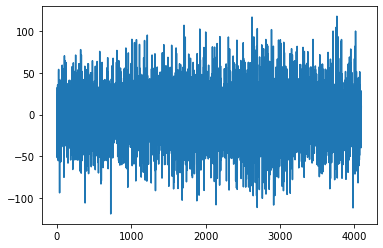

In [252]:
with h5py.File("../input/ggwp/output/test1.h5", "r") as f:
    print(f.keys())
    print(f["injection_samples"].keys())
    times = np.array(f["injection_samples"]["event_time"])
    
    injections_shape = f["injection_samples"]["h1_strain"].shape
    print(f["noise_samples"]["event_time"][0])
    print(f["command_line_arguments"].keys())
    
#     targets = np.array(f["injection_samples"])
    plt.plot(f["injection_samples"]["v1_strain"][0])

In [253]:
with h5py.File("../input/ggwp/output/test3.h5", "r") as f:
#     injection_samples = 
    print(f["injection_samples"].keys())
    injection_event_times_ = np.array(f["injection_samples"]["event_time"])
    noise_samples = f["noise_samples"]
    print(f["injection_parameters"])
    injection_shape = f["injection_samples"]["h1_strain"].shape
    noise_shape = f["noise_samples"]["h1_strain"].shape
    injections_h1 = np.array(f["injection_samples"]["h1_strain"])
    noise_h1 = np.array(f["noise_samples"]["h1_strain"])
    injections_l1 = np.array(f["injection_samples"]["l1_strain"])
    noise_l1 = np.array(f["noise_samples"]["l1_strain"])
    injections_v1 = np.array(f["injection_samples"]["v1_strain"])
    noise_v1 = np.array(f["noise_samples"]["v1_strain"])


<KeysViewHDF5 ['event_time', 'h1_strain', 'l1_strain', 'v1_strain']>
<HDF5 group "/injection_parameters" (17 members)>


In [262]:
with h5py.File("../input/ggwp/output/test3.h5", "r") as f:
    snrs = np.array(f["injection_parameters"]["v1_snr"])
#     print(f["injection_parameters"]["l1_snr"].keys())

In [278]:
if injection_shape[1] == noise_shape[1]:
    ds_shape = (injection_shape[0] + noise_shape[0], injection_shape[1],3)
    targets = np.zeros(ds_shape[0], dtype=np.uint8)
    timeseries = np.zeros(ds_shape)
    targets[:injection_shape[0]] = 1
    targets[injection_shape[0]:] = 0
    timeseries[:injection_shape[0],:,0] = injections_h1
    timeseries[injection_shape[0]:,:,0] = noise_h1
    timeseries[:injection_shape[0],:,1] = injections_l1
    timeseries[injection_shape[0]:,:,1] = noise_l1
    timeseries[:injection_shape[0],:,2] = injections_v1
    timeseries[injection_shape[0]:,:,2] = noise_v1
    
    
for i in range(timeseries.shape[0]):
    timeseries[i] /= abs(timeseries[i]).max()    
    

In [292]:
output_file = "test00.tfrec"
writer = tf.io.TFRecordWriter(output_file)
indices = np.arange(targets.shape[0])
np.random.shuffle(indices)

for i in tqdm(range(timeseries.shape[0])):
    X = timeseries[indices[i]]
    y = targets[indices[i]]
    feature={}
    feature["TimeSeries"] = tf.train.Feature(float_list=tf.train.FloatList(value=X.flatten()))
    feature["Target"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[y]))
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()
    writer.write(serialized)
writer.close()

  0%|          | 0/100000 [00:00<?, ?it/s]

In [291]:
indices = np.arange(targets.shape[0])
np.random.shuffle(indices)
indices

array([88059, 56895, 38466, ..., 28659, 93351, 71684])

In [288]:
np.random.shuffle(np.arange(timeseries.shape[0]))

In [182]:

# abs(timeseries).max(axis=1).max(axis=1) 


AttributeError: 'numpy.ndarray' object has no attribute 'axis'

(6400, 4096, 3)